In [1]:
import napari
import napari_stress
import napari_process_points_and_surfaces as nppas
import vedo
import tqdm

from skimage import io, filters
import pandas as pd
import os
import numpy as np

In [2]:
# create viewer
viewer = napari.Viewer(ndisplay=3)

INFO:xmlschema:Resource 'XMLSchema.xsd' is already loaded
Plugin 'napari-spatial-statistics' provided a non-callable type to `napari_experimental_provide_function`: <class 'sip.wrappertype'>. Function widget ignored.


In [3]:
directory = r'C:\Users\johamuel\Documents\BiAPoL\Shared\BiAPoLprojects\20_STRESS\1_first_data'
raw = io.imread(os.path.join(directory, 'ExampleTifSequence-InteriorLabel-vsx_2.076um-vsz_3.998um-TimeInterval_3.00min-21timesteps.tif'))

In [4]:
# Config
vsz = 3.998
vsy = 2.076
vsx = 2.076
n_frames = raw.shape[0]

In [5]:
viewer.add_image(raw, scale=[vsz, vsy, vsx], name='Raw data')

INFO:OpenGL.acceleratesupport:No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


<Image layer 'Raw data' at 0x1dda2869a90>

## Preprocess

We first resample the image to isotropic voxel size and create a binary mask

In [6]:
# Resample
resampled_image = []
for t in range(n_frames):
    resampled_image.append(napari_stress.resample(raw[t], vsz=vsz, vsy=vsy, vsx=vsx))
resampled_image = np.asarray(resampled_image)
viewer.add_image(resampled_image, scale = 3 * [np.min([vsz, vsy, vsx])])

<Image layer 'resampled_image' at 0x1dda287b310>

In [7]:
# Masking
binary_image = resampled_image > filters.threshold_otsu(resampled_image)
binary_image_layer = viewer.add_labels(binary_image, scale = 3 * [np.min([vsz, vsy, vsx])])

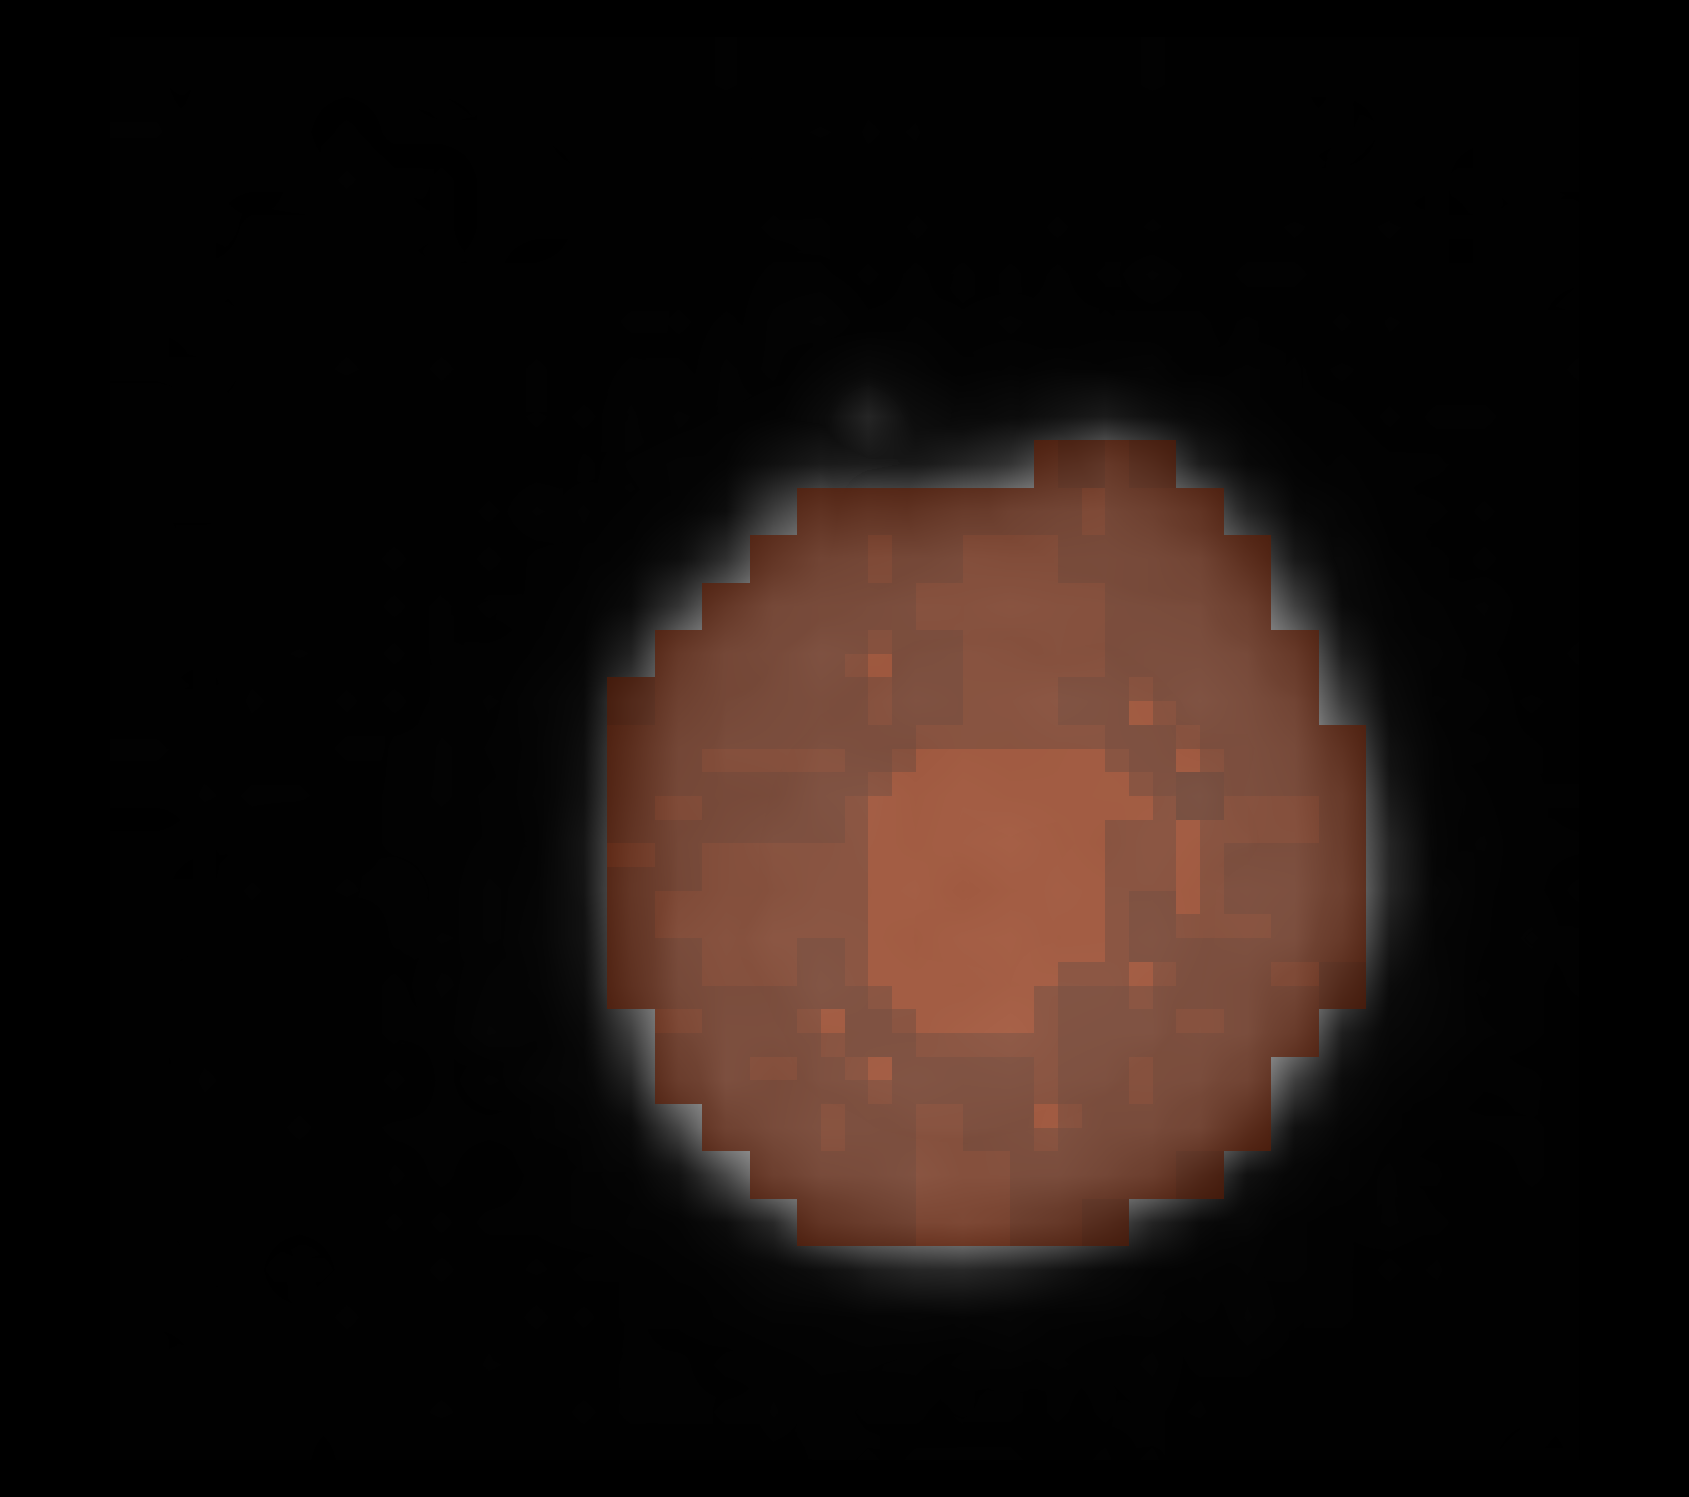

In [8]:
napari.utils.nbscreenshot(viewer, canvas_only=True)

# Create surface

We use the marching cubes algorithm to create a surface from the binary image. We then smooth the surface a bit.

In [9]:
# Create surface
surface = napari_stress.surface_from_label(binary_image, scale = 3 * [np.min([vsz, vsy, vsx])])
surface_layer = viewer.add_surface(napari_stress.list_of_surfaces_to_surface(surface))

Alternative shading modes are only available in 3D, defaulting to none


In [10]:
# Smooth surface
smoothed_surfaces = []
for t in range(n_frames):
    points = surface[t].points()
    faces = surface[t].faces()
    smoothed_surf = nppas.filter_smooth_laplacian((points, faces), number_of_iterations=3)
    smoothed_surfaces.append(vedo.mesh.Mesh((smoothed_surf[0], smoothed_surf[1])))
        
smoothed_surface_layer = viewer.add_surface(napari_stress.list_of_surfaces_to_surface(smoothed_surfaces), name='Smoothed surface')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Alternative shading modes are only available in 3D, defaulting to none


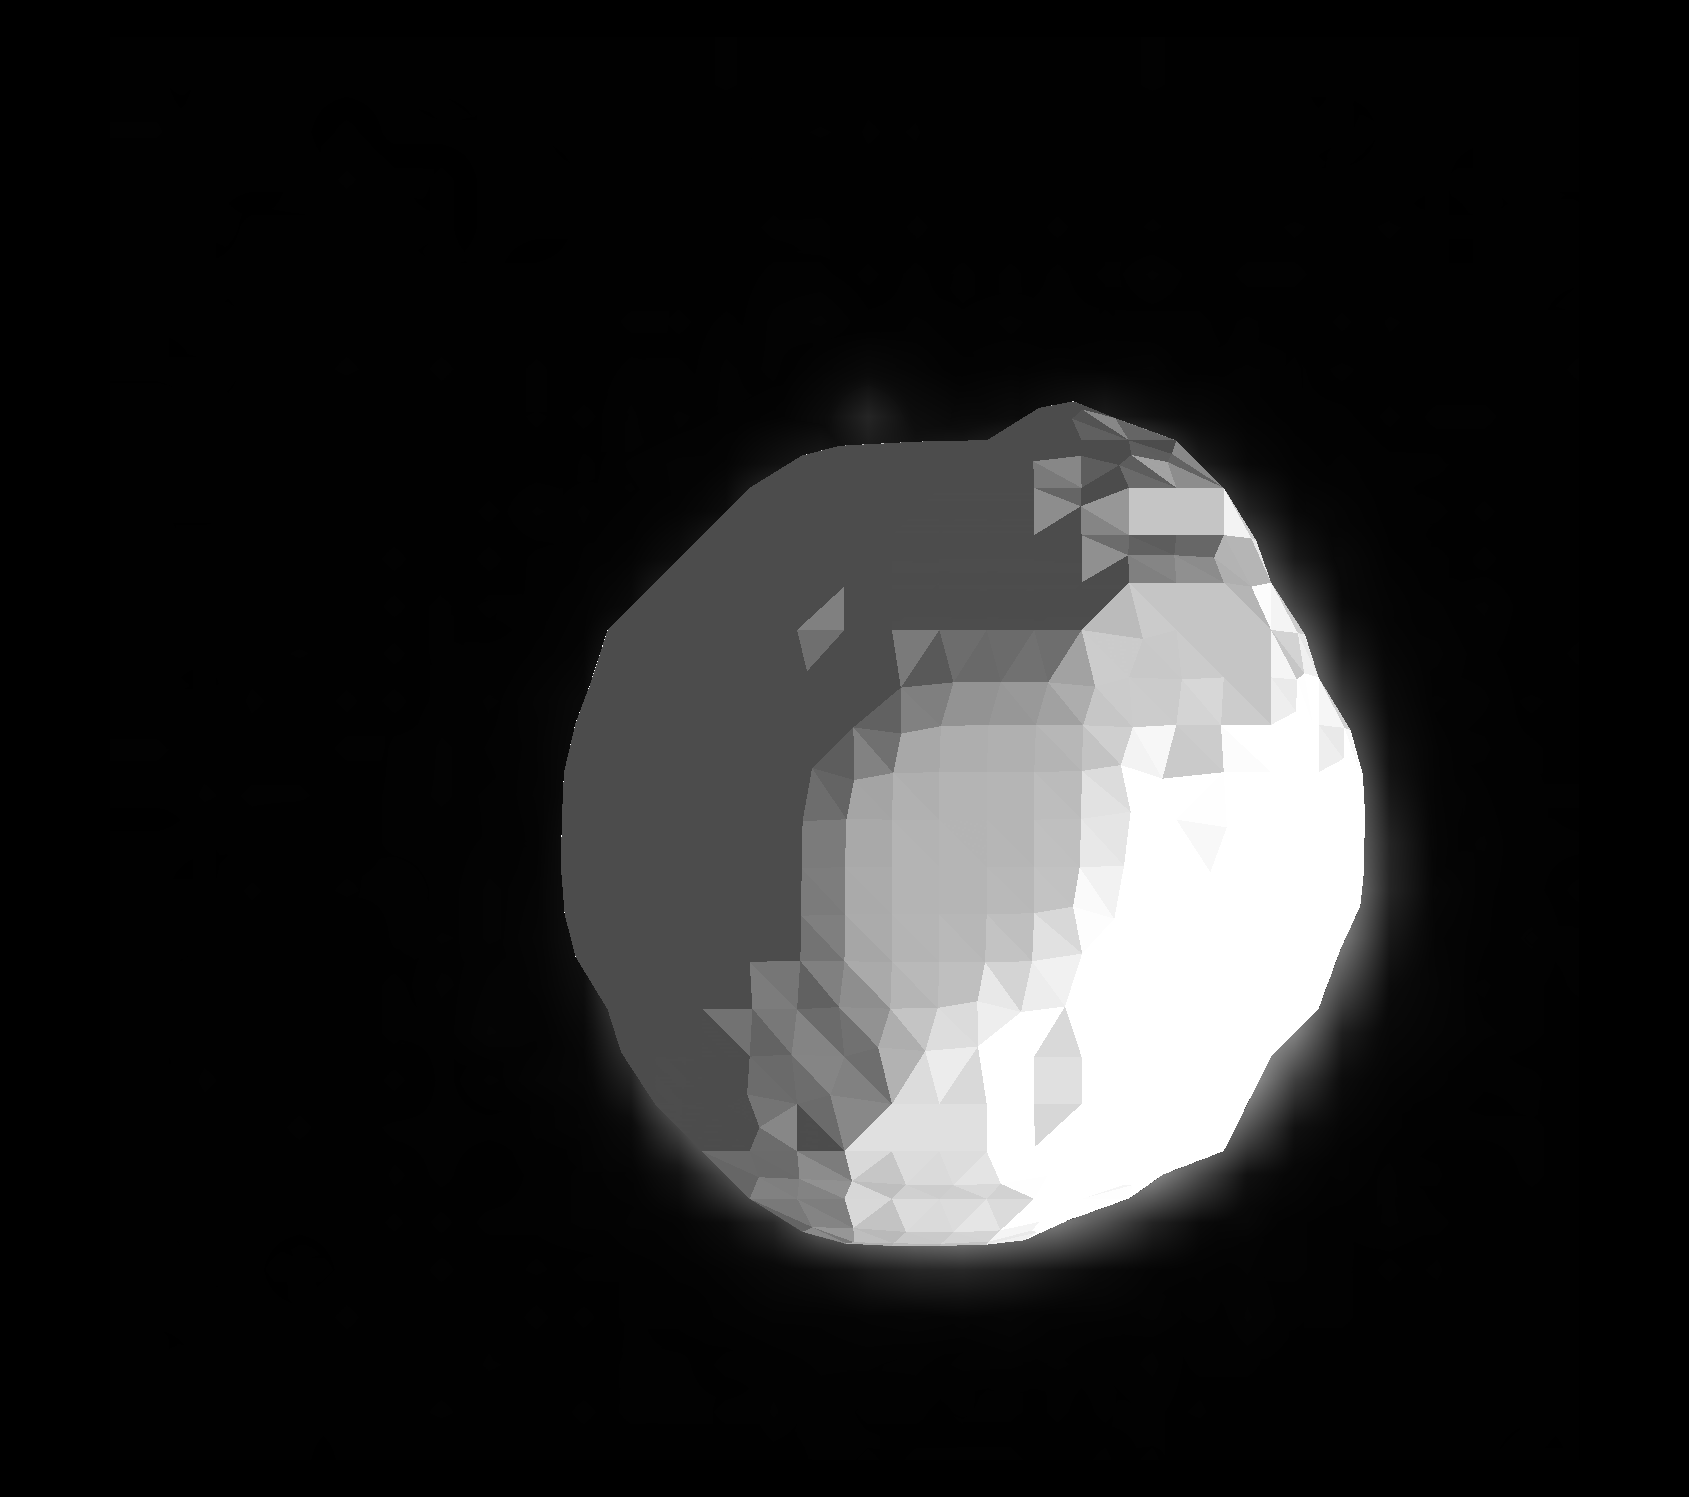

In [11]:
binary_image_layer.visible = False
surface_layer.visible = False
napari.utils.nbscreenshot(viewer, canvas_only=True)

## Surface refinement

In the next step, we will trace-refine the surface, filter the detected points and resample the density of the vertices on the surface to a defined value.

In [12]:
# Trace refinement
results = []
for t in tqdm.tqdm(range(n_frames)):
    vertices = smoothed_surfaces[t].points()
    faces = smoothed_surfaces[t].faces()
    result = napari_stress.trace_refinement_of_surface(resampled_image[t], (vertices, faces),
                                                      trace_length=10.0, sampling_distance=0.1,
                                                      scale=binary_image_layer.scale[1:],
                                                      show_progress=False)
    pts4d = np.insert(np.stack(result['surface_points'].to_numpy()), 0, np.repeat(t, len(result)), axis=1)
    vec4d = np.insert(np.stack(result['projection_vector'].to_numpy()), 0, np.repeat(t, len(result)), axis=1)
    result['surface_points'] = list(pts4d)
    result['projection_vector'] = list(vec4d)
    results.append(result)
    
    
results = pd.concat(results, ignore_index=True)
result

 24%|███████████████████▊                                                               | 5/21 [00:34<02:02,  7.66s/it]Covariance of the parameters could not be estimated
overflow encountered in exp
 76%|██████████████████████████████████████████████████████████████▍                   | 16/21 [01:44<00:30,  6.19s/it]Covariance of the parameters could not be estimated
overflow encountered in exp
100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [02:10<00:00,  6.20s/it]


,index,surface_points,idx_of_border,projection_vector,center,amplitude,slope,offset,center_err,amplitude_err,slope_err,offset_err,profiles
1,1,"[20.0, 16.153767099379184, 25.503929929733502,...",58.678585,"[20.0, 10.965266819000245, 4.002220576286316, ...",58.678585,0.790735,0.096676,0.026084,0.121840,0.003578,0.001074,0.001621,"[0.025301926667211753, 0.02578722146186713, 0...."
2,2,"[20.0, 16.18231621742143, 23.5953035888761, 31...",58.829590,"[20.0, 10.995687864303589, 5.059068537712097, ...",58.829590,0.780950,0.104856,0.021825,0.128362,0.003728,0.001310,0.001735,"[0.01723459574751938, 0.0177033339882538, 0.01..."
3,3,"[20.0, 15.912565658568457, 25.36507668113598, ...",57.273284,"[20.0, 10.871223014831543, 3.5677414083480836,...",57.273284,0.780321,0.100117,0.026463,0.127186,0.003666,0.001206,0.001773,"[0.026034374458356806, 0.02670883003613903, 0...."
4,4,"[20.0, 15.925757924451444, 27.683962218473855,...",63.819476,"[20.0, 12.046976469039917, 3.9062880163192752,...",63.819476,-0.801718,-0.088887,0.830003,0.148280,0.004455,0.001041,0.003597,"[0.02438434907888607, 0.025408034770975113, 0...."
5,6,"[20.0, 16.133652048110015, 25.431472931387177,...",58.511740,"[20.0, 11.010138628005981, 3.570981149196625, ...",58.511740,0.785836,0.098041,0.026926,0.120354,0.003510,0.001089,0.001610,"[0.02542119831986561, 0.02590779436718022, 0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1206,1219,"[20.0, 48.99409214076544, 23.08640402410427, 2...",49.642417,"[20.0, -8.71612691116333, -3.6789899168014526,...",49.642417,0.476248,0.080168,0.009074,0.223445,0.004028,0.001514,0.002349,"[0.02108714847909043, 0.022027995716450883, 0...."
1209,1222,"[20.0, 49.882730604170874, 22.855214972020846,...",49.701103,"[20.0, -9.765799976348877, -3.1951175079345706...",49.701103,-0.493013,-0.063943,0.501831,0.257125,0.005143,0.001247,0.002901,"[0.03170599291668233, 0.03316906855929867, 0.0..."
1220,1233,"[20.0, 50.91001224449337, 19.394435101608504, ...",49.799519,"[20.0, -10.011165985107422, 1.0374337692260742...",49.799519,0.460673,0.072633,0.009114,0.172778,0.003097,0.001008,0.001761,"[0.0247521174273589, 0.0248211160634214, 0.024..."
1221,1234,"[20.0, 50.96355975055616, 18.84528893603624, 2...",49.410287,"[20.0, -9.695826919555664, 2.9800861744880676,...",49.410287,0.445497,0.076989,0.014320,0.169752,0.002893,0.001081,0.001685,"[0.025606018715516213, 0.025980714792014074, 0..."


In [15]:
points = np.stack(results['surface_points'].to_numpy())
vectors = np.stack(results['projection_vector'].to_numpy())
viewer.add_points(points, size=0.2)
viewer.add_vectors(np.stack([points, vectors]).transpose((1,0,2)), edge_width=0.2)

<Vectors layer 'Vectors' at 0x1ddccab0490>

In [17]:
np.stack([points, vectors]).transpose((1,0,2)).shape

(23606, 2, 4)

In [16]:
vectors.shape

(23606, 4)